# Linear Regression

A very simple linear regression model to serve as a benchmark against which the performance of other techniques can be compared. We will not try to optimise this model.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.options.display.max_columns = 999

# Load Dataset

In [2]:
hec = pd.read_csv('../datasets/household-electricity.csv', parse_dates=[0])
print(hec.shape)
hec.head()

(26305, 322)


,DateTime,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,household_10,household_11,household_12,household_13,household_14,household_15,household_16,household_17,household_18,household_19,household_20,household_21,household_22,household_23,household_24,household_25,household_26,household_27,household_28,household_29,household_30,household_31,household_32,household_33,household_34,household_35,household_36,household_37,household_38,household_39,household_40,household_41,household_42,household_43,household_44,household_45,household_46,household_47,household_48,household_49,household_50,household_51,household_52,household_53,household_54,household_55,household_56,household_57,household_58,household_59,household_60,household_61,household_62,household_63,household_64,household_65,household_66,household_67,household_68,household_69,household_70,household_71,household_72,household_73,household_74,household_75,household_76,household_77,household_78,household_79,household_80,household_81,household_82,household_83,household_84,household_85,household_86,household_87,household_88,household_89,household_90,household_91,household_92,household_93,household_94,household_95,household_96,household_97,household_98,household_99,household_100,household_101,household_102,household_103,household_104,household_105,household_106,household_107,household_108,household_109,household_110,household_111,household_112,household_113,household_114,household_115,household_116,household_117,household_118,household_119,household_120,household_121,household_122,household_123,household_124,household_125,household_126,household_127,household_128,household_129,household_130,household_131,household_132,household_133,household_134,household_135,household_136,household_137,household_138,household_139,household_140,household_141,household_142,household_143,household_144,household_145,household_146,household_147,household_148,household_149,household_150,household_151,household_152,household_153,household_154,household_155,household_156,household_157,household_158,household_159,household_160,household_161,household_162,household_163,household_164,household_165,household_166,household_167,household_168,household_169,household_170,household_171,household_172,household_173,household_174,household_175,household_176,household_177,household_178,household_179,household_180,household_181,household_182,household_183,household_184,household_185,household_186,household_187,household_188,household_189,household_190,household_191,household_192,household_193,household_194,household_195,household_196,household_197,household_198,household_199,household_200,household_201,household_202,household_203,household_204,household_205,household_206,household_207,household_208,household_209,household_210,household_211,household_212,household_213,household_214,household_215,household_216,household_217,household_218,household_219,household_220,household_221,household_222,household_223,household_224,household_225,household_226,household_227,household_228,household_229,household_230,household_231,household_232,household_233,household_234,household_235,household_236,household_237,household_238,household_239,household_240,household_241,household_242,household_243,household_244,household_245,household_246,household_247,household_248,household_249,household_250,household_251,household_252,household_253,household_254,household_255,household_256,household_257,household_258,household_259,household_260,household_261,household_262,household_263,household_264,household_265,household_266,household_267,household_268,household_269,household_270,household_271,household_272,household_273,household_274,household_275,household_276,household_277,household_278,household_279,household_280,household_281,household_282,household_283,household_284,household_285,household_286,household_287,household_288,household_289,household_290,household_291,household_29

In [3]:
test_length = 500

# Example Linear Regression Model

First, we create some functions to readily prepare datasets for each household.

In [4]:
def select_household(household):
    df = hec.iloc[:, [0, household+1]]
    return df

In [5]:
def create_features(household_df, window=24):
    df = household_df.copy()
    # One hot encode day of week
    day_names = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
    for i in range(7):
        df[day_names[i]] = (df['DateTime'].dt.dayofweek == i).astype(int)

    # One hot encode hour of day
    hour_names = ['hour_%s' % str(i) for i in range(24)]
    for i in range(24):
        df[hour_names[i]] = (df['DateTime'].dt.hour == i).astype(int)

    # Continuous variable for years
    df['annual'] = (df['DateTime'] - df['DateTime'][0]).dt.days / 365

    # Moving average
    df['ma'] = df.iloc[:, 1].rolling(window).mean()
    df['ma'] = df['ma'].shift(test_length)
    df.dropna(inplace=True)
    
    return df

In [6]:
def split_data(df, test_length=test_length):
    X_train = df.iloc[:-test_length, 2:]
    X_test = df.iloc[-test_length:, 2:]

    y_train = df.iloc[:-test_length, 1]
    y_test = df.iloc[-test_length:, 1]
    
    return X_train, X_test, y_train, y_test

Illustrate model for an example household. Ridge regression is a sensible choice for regularising our model.

In [7]:
from sklearn.linear_model import Ridge

household = 1
df = select_household(household)
df = create_features(df)
X_train, X_test, y_train, y_test = split_data(df)

lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[y_pred < 0] = 0
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))
scale = np.mean(y_test)
sRMSE = RMSE / scale
print(sRMSE)

0.15260963224933022


Plot example predictions.

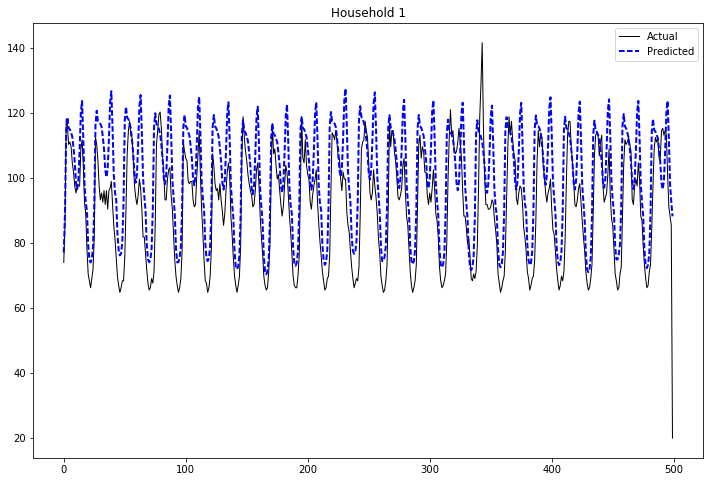

In [8]:
plt.plot(y_test.values, label='Actual', c='k', linewidth=1)
plt.plot(y_pred, label='Predicted', c='b', linestyle='--', linewidth=2)
plt.legend()
plt.title('Household %s' % household);

Examine example linear regression model coefficients.

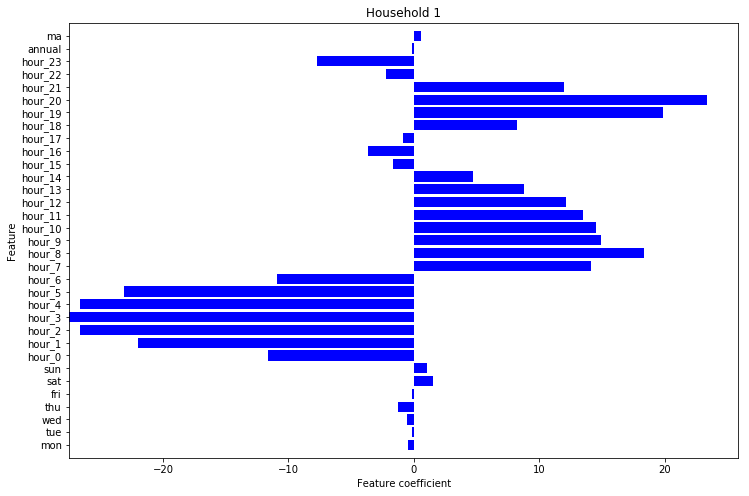

In [9]:
coefs = lr.coef_
cols = df.columns[2:]
params = pd.Series(coefs, index=cols)

fig, ax = plt.subplots()
ax.barh(range(len(params)), params.values, align='center', color='b')
plt.xlabel('Feature coefficient')
plt.yticks(np.arange(len(params)), params.index)
plt.ylabel('Feature')
plt.ylim(-1, len(params))
plt.title('Household %s' % household);

# Evaluate Linear Regresion

In [10]:
results = hec.iloc[-test_length:].copy()

for household in range(len(hec.columns)-1):
    df = select_household(household)
    df = create_features(df)
    X_train, X_test, y_train, y_test = split_data(df)

    lr = Ridge()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    RMSE = np.sqrt(np.mean(np.square(y_pred - y_test)))
    scale = np.mean(y_test)
    sRMSE = RMSE / scale
    results['household_%s_pred' % household] = y_pred

In [11]:
results0 = results.iloc[:, 1:].copy()
results0[results0 < 0] = 0
results0['DateTime'] = results['DateTime']

In [12]:
results0.head()

,household_0,household_1,household_2,household_3,household_4,household_5,household_6,household_7,household_8,household_9,household_10,household_11,household_12,household_13,household_14,household_15,household_16,household_17,household_18,household_19,household_20,household_21,household_22,household_23,household_24,household_25,household_26,household_27,household_28,household_29,household_30,household_31,household_32,household_33,household_34,household_35,household_36,household_37,household_38,household_39,household_40,household_41,household_42,household_43,household_44,household_45,household_46,household_47,household_48,household_49,household_50,household_51,household_52,household_53,household_54,household_55,household_56,household_57,household_58,household_59,household_60,household_61,household_62,household_63,household_64,household_65,household_66,household_67,household_68,household_69,household_70,household_71,household_72,household_73,household_74,household_75,household_76,household_77,household_78,household_79,household_80,household_81,household_82,household_83,household_84,household_85,household_86,household_87,household_88,household_89,household_90,household_91,household_92,household_93,household_94,household_95,household_96,household_97,household_98,household_99,household_100,household_101,household_102,household_103,household_104,household_105,household_106,household_107,household_108,household_109,household_110,household_111,household_112,household_113,household_114,household_115,household_116,household_117,household_118,household_119,household_120,household_121,household_122,household_123,household_124,household_125,household_126,household_127,household_128,household_129,household_130,household_131,household_132,household_133,household_134,household_135,household_136,household_137,household_138,household_139,household_140,household_141,household_142,household_143,household_144,household_145,household_146,household_147,household_148,household_149,household_150,household_151,household_152,household_153,household_154,household_155,household_156,household_157,household_158,household_159,household_160,household_161,household_162,household_163,household_164,household_165,household_166,household_167,household_168,household_169,household_170,household_171,household_172,household_173,household_174,household_175,household_176,household_177,household_178,household_179,household_180,household_181,household_182,household_183,household_184,household_185,household_186,household_187,household_188,household_189,household_190,household_191,household_192,household_193,household_194,household_195,household_196,household_197,household_198,household_199,household_200,household_201,household_202,household_203,household_204,household_205,household_206,household_207,household_208,household_209,household_210,household_211,household_212,household_213,household_214,household_215,household_216,household_217,household_218,household_219,household_220,household_221,household_222,household_223,household_224,household_225,household_226,household_227,household_228,household_229,household_230,household_231,household_232,household_233,household_234,household_235,household_236,household_237,household_238,household_239,household_240,household_241,household_242,household_243,household_244,household_245,household_246,household_247,household_248,household_249,household_250,household_251,household_252,household_253,household_254,household_255,household_256,household_257,household_258,household_259,household_260,household_261,household_262,household_263,household_264,household_265,household_266,household_267,household_268,household_269,household_270,household_271,household_272,household_273,household_274,household_275,household_276,household_277,household_278,household_279,household_280,household_281,household_282,household_283,household_284,household_285,household_286,household_287,household_288,household_289,household_290,household_291,household_292,househo

In [13]:
sRMSEs = []
for i in range(len(hec.columns)-1):
    RMSE = np.sqrt(np.mean(np.square(results0['household_%s' % i] - results0['household_%s_pred' % i])))
    scale = np.mean(results0['household_%s' % i])
    sRMSE = RMSE/scale
    sRMSEs.append(sRMSE)

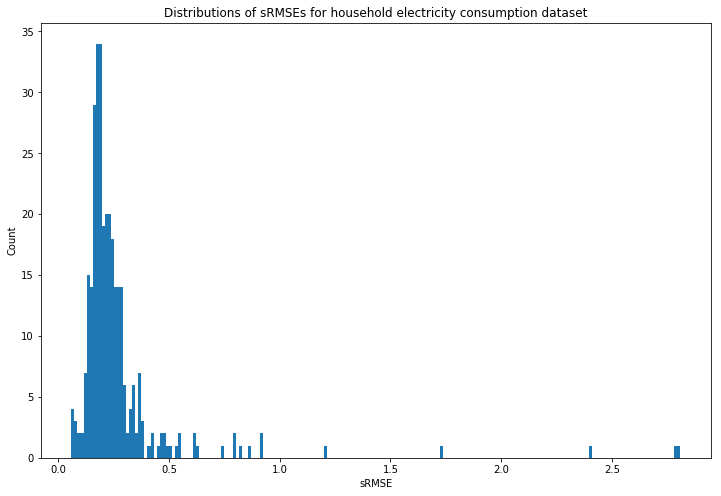

In [14]:
plt.hist(sRMSEs, bins=200)
plt.title('Distributions of sRMSEs for household electricity consumption dataset')
plt.xlabel('sRMSE')
plt.ylabel('Count');

In [15]:
sRMSE = np.mean(sRMSEs)
sRMSE

0.2702365218934098

Show some example forecasts.

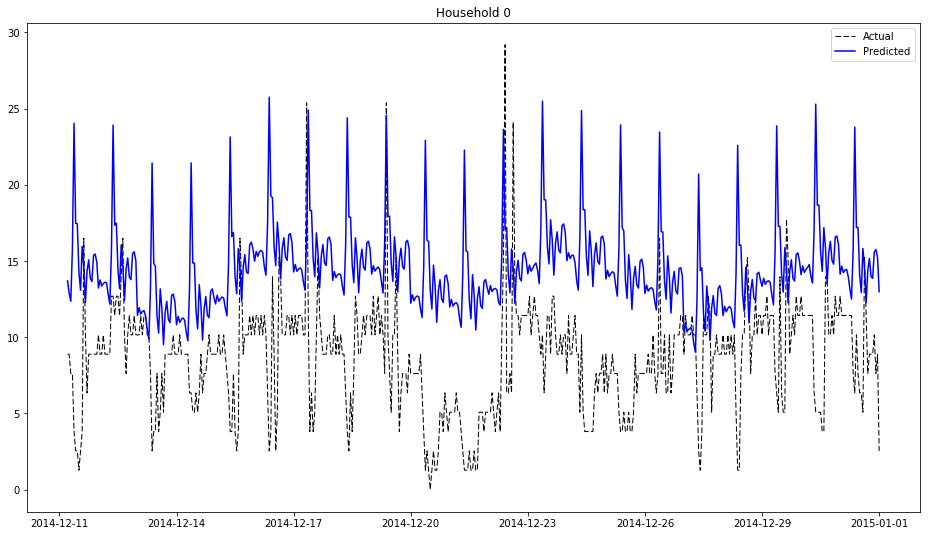

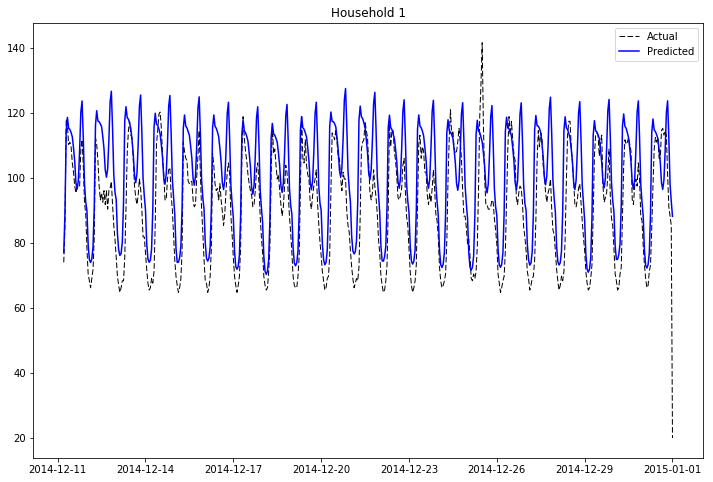

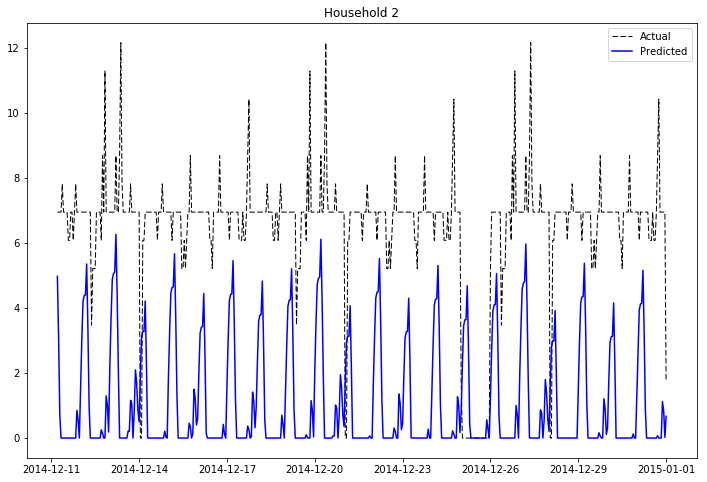

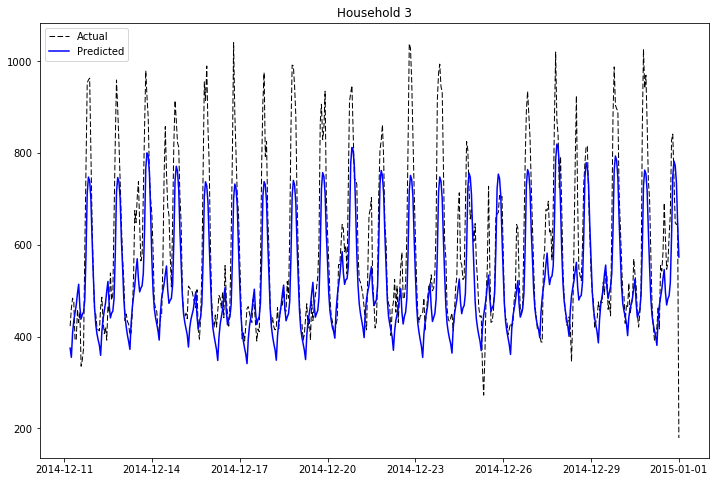

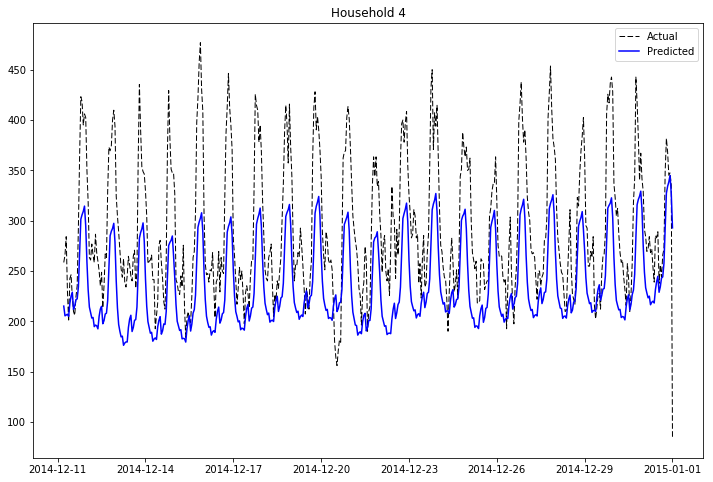

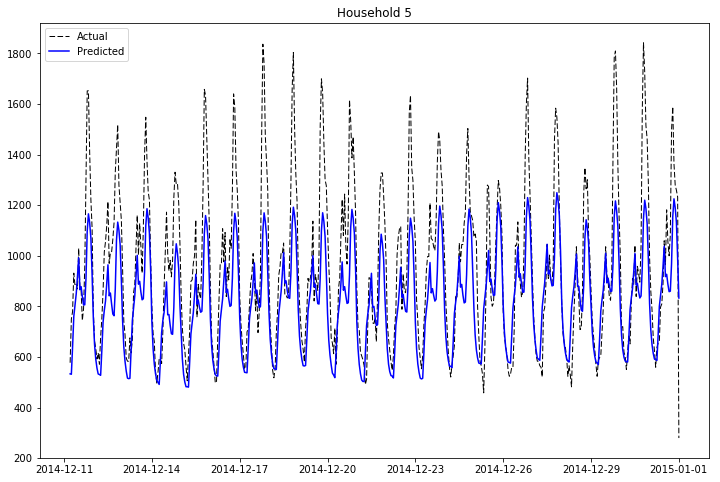

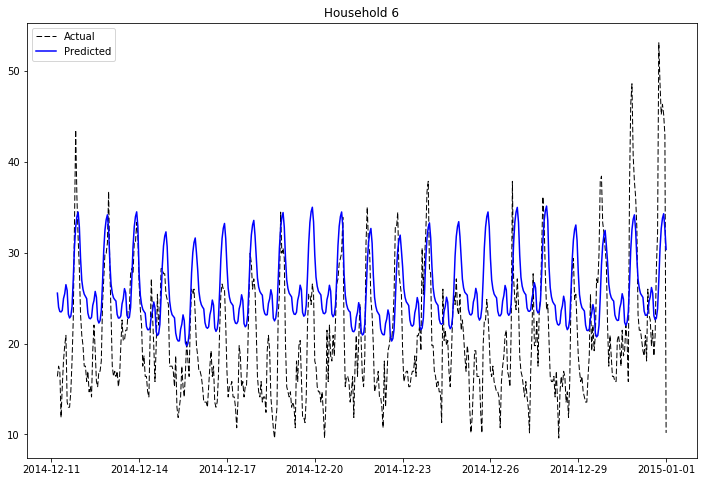

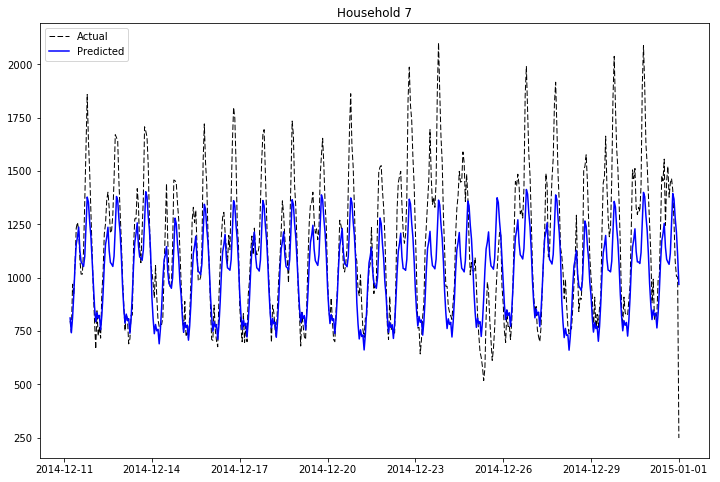

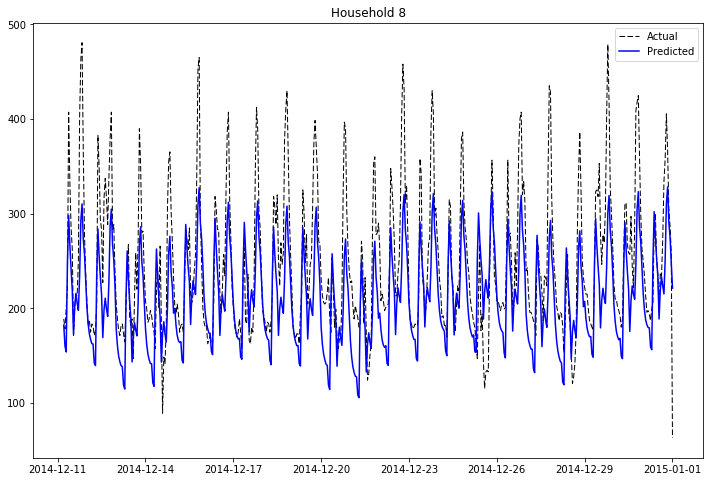

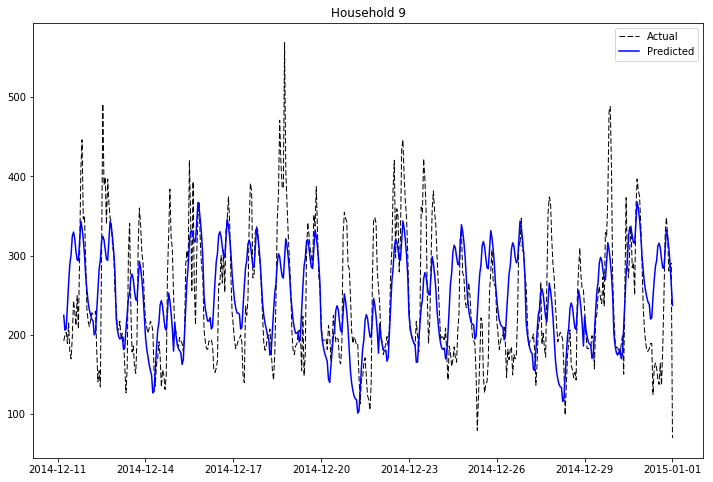

In [16]:
fig = plt.figure(figsize=(16, 9))
for household in range(10):
    plt.plot(results0['DateTime'][-1000:], results0['household_%s' % household][-1000:],
             label='Actual', c='k', linestyle='--', linewidth=1)
    plt.plot(results0['DateTime'][-500:], results0['household_%s_pred' % household][-500:],
             label='Predicted', c='b')
    plt.legend()
    plt.title('Household %s' % household)
    plt.show()

Store the raw results and the computed sRMSE accuracy score for the Prophet models.

In [17]:
import pickle

with open('hec-results.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open('hec-sRMSE.pkl', 'wb') as f:
    pickle.dump(sRMSE, f)